## Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Load the data

In [2]:
# Load the Titanic dataset
df = pd.read_csv('titanic.csv')

## Exploring the data

In [3]:
# Showing head of data (first 5 rows of data)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df.describe().style.background_gradient(cmap='nipy_spectral')

,survived,pclass,age,sibsp,parch,fare
count,889.000000,889.000000,713.000000,889.000000,889.000000,889.000000
mean,0.384702,2.307087,29.698696,0.523060,0.382452,32.259059
std,0.486799,0.836367,14.536691,1.103729,0.806761,49.735870
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.000000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Inspect the dataset
print("Initial Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     889 non-null    int64  
 1   pclass       889 non-null    int64  
 2   sex          889 non-null    object 
 3   age          713 non-null    float64
 4   sibsp        889 non-null    int64  
 5   parch        889 non-null    int64  
 6   fare         889 non-null    float64
 7   embarked     887 non-null    object 
 8   class        889 non-null    object 
 9   who          889 non-null    object 
 10  adult_male   889 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  887 non-null    object 
 13  alive        889 non-null    object 
 14  alone        889 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.2+ KB
None

Missing Values:
survived         0
pclass           0
sex              0
age     

## Data Preprocessing


### Handling duplicates rows

In [6]:
# Check for duplicates rows
print("\nDuplicated Rows:")
print(df.duplicated().sum())


Duplicated Rows:
107


In [7]:
# Remove duplicates
df.drop_duplicates(inplace=True)

### Handling missing values

In [8]:
# Define columns with missing values
columns_with_missing = ['age', 'embarked','deck','embark_town']

# Drop columns with more than 50% missing values
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Columns with missing values after dropping columns
columns_with_missing = df.columns[df.isnull().any()].tolist()

# Forward fill missing values for remaining columns
df[columns_with_missing] = df[columns_with_missing].fillna(method='ffill')

C:\Users\dell\AppData\Local\Temp\ipykernel_8536\1772724018.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[columns_with_missing] = df[columns_with_missing].fillna(method='ffill')


In [9]:
print("Initial Dataset Info:")
print(df.info())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 0 to 888
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     782 non-null    int64  
 1   pclass       782 non-null    int64  
 2   sex          782 non-null    object 
 3   age          782 non-null    float64
 4   sibsp        782 non-null    int64  
 5   parch        782 non-null    int64  
 6   fare         782 non-null    float64
 7   embarked     782 non-null    object 
 8   class        782 non-null    object 
 9   who          782 non-null    object 
 10  adult_male   782 non-null    bool   
 11  embark_town  782 non-null    object 
 12  alive        782 non-null    object 
 13  alone        782 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(6)
memory usage: 80.9+ KB
None


### Defining categorical and numerical columns

In [10]:
# define the target variable as categorical
df['survived'] = df['survived'].astype('category')

# Define numerical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Handle categorical data
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

In [11]:
print("Categorical Columns:" + str(categorical_columns))
print("Numerical Columns:" + str(numeric_features))

Categorical Columns:['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']
Numerical Columns:['pclass', 'age', 'sibsp', 'parch', 'fare']


### Handling Categorical Data

In [12]:
for column in categorical_columns:
    df[column] = pd.Categorical(df[column])
    df[column] = df[column].cat.codes

### Data Visualization

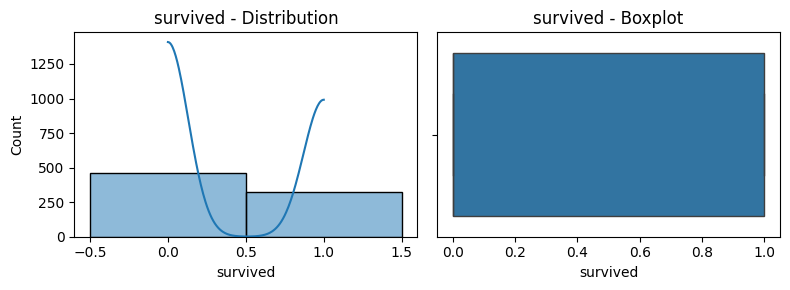

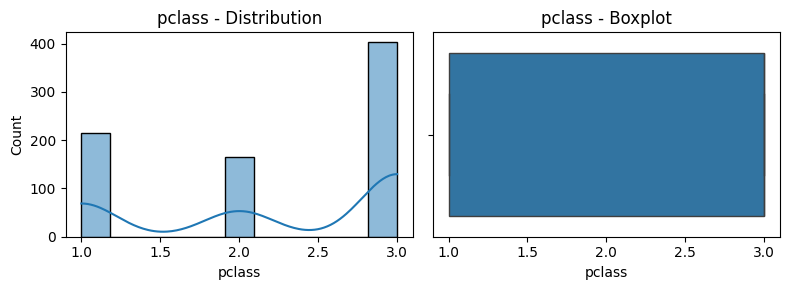

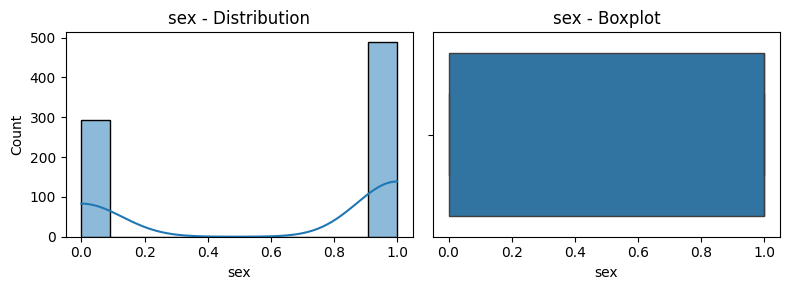

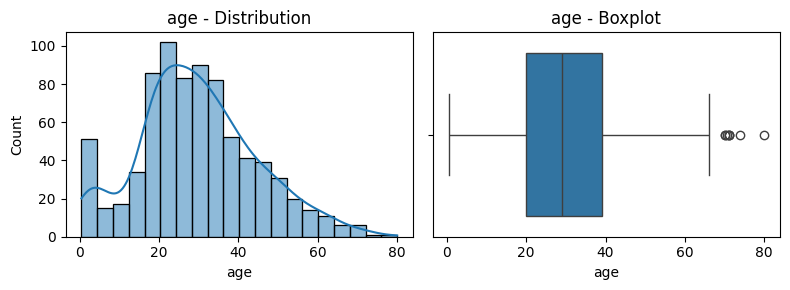

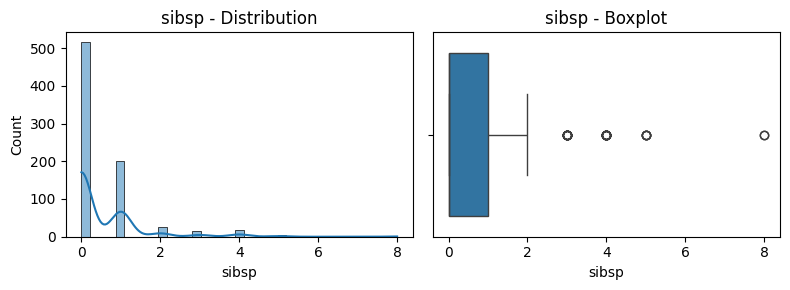

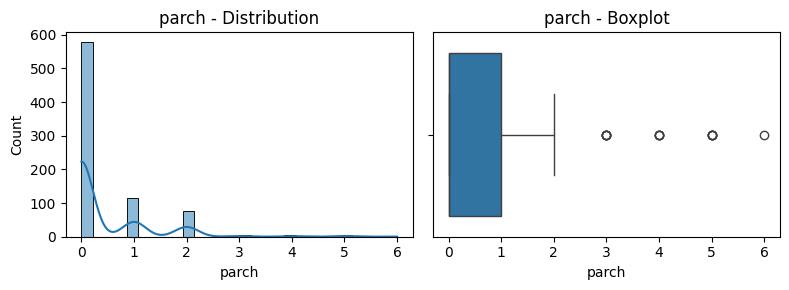

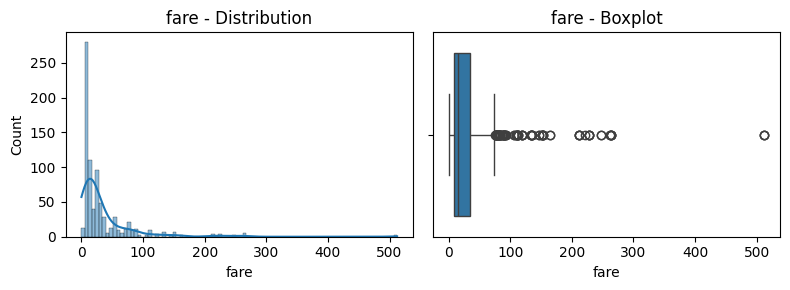

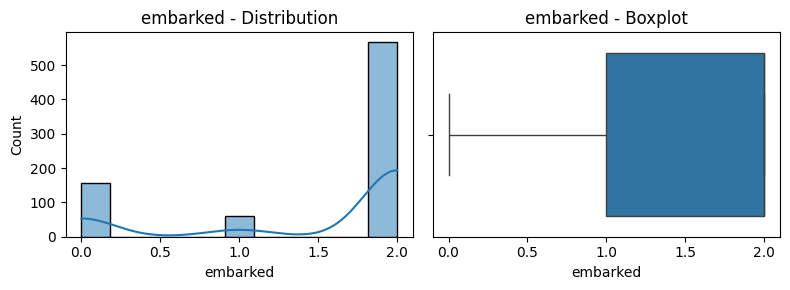

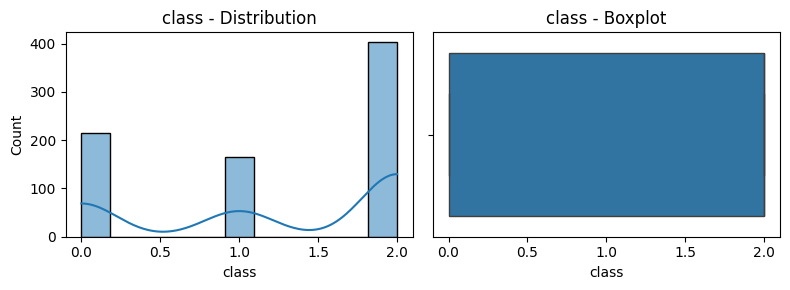

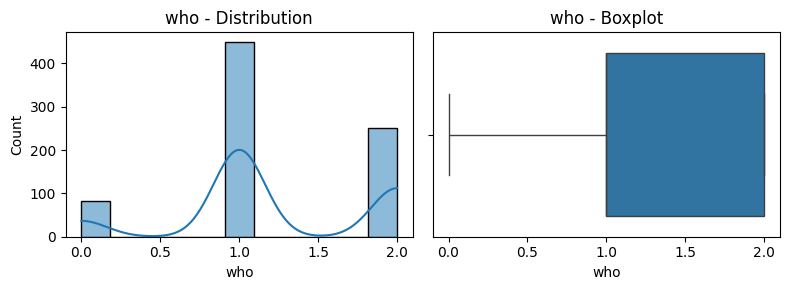

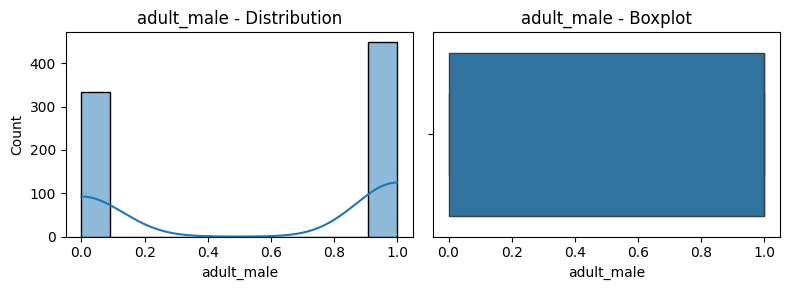

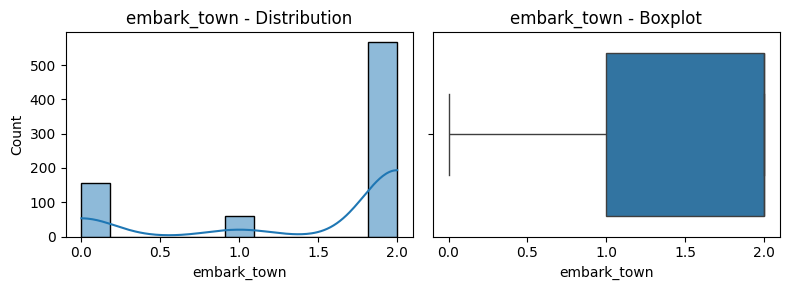

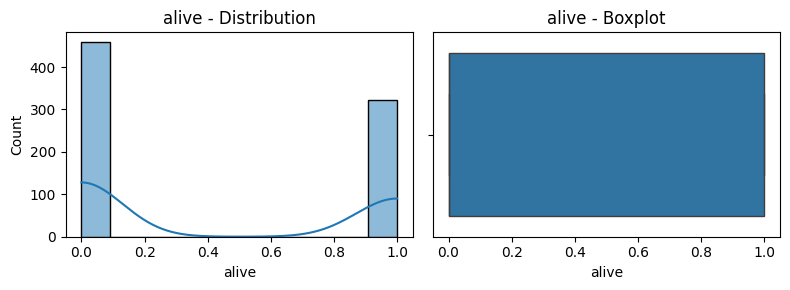

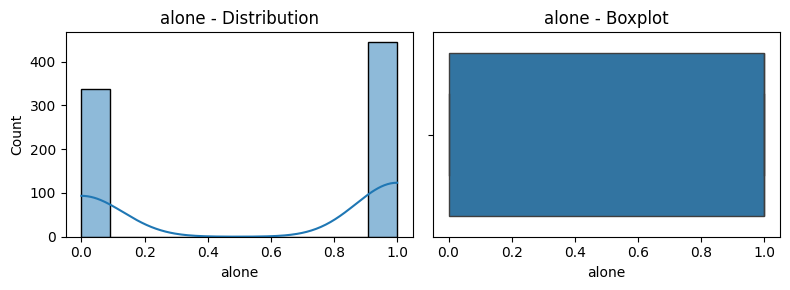

In [13]:
for column in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  
    sns.histplot(data=df[column], kde=True, ax=axes[0])
    sns.boxplot(data=df[column], ax=axes[1], orient='h')
    axes[0].set_title(f'{column} - Distribution')
    axes[1].set_title(f'{column} - Boxplot')
    plt.tight_layout()
    plt.show()

### Removing Outliers

From the plotting we can see that there are outliers in our data, So i will use Interquartile range

In [14]:
# Handle outliers using IQR method
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with median
for feature in numeric_features:
    df[feature] = np.where((df[feature] < lower_bound[feature]) | (df[feature] > upper_bound[feature]), df[feature].median(), df[feature])

# Scale numerical features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


### Visualizing the data after removing outliers

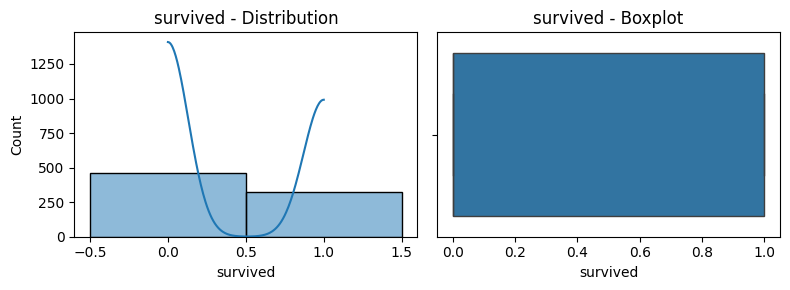

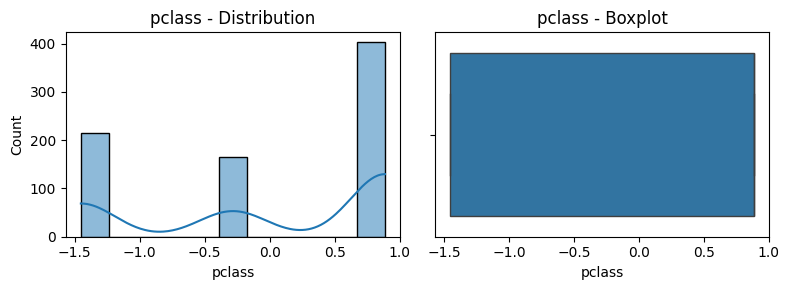

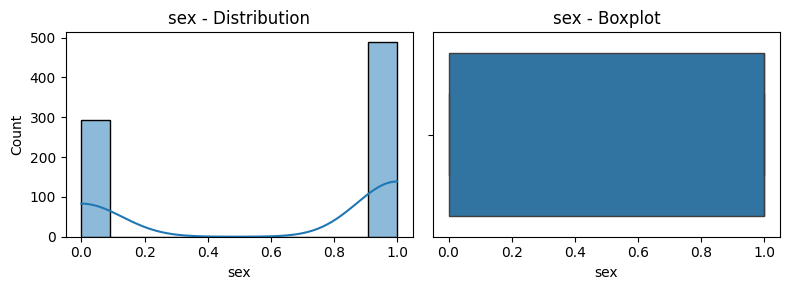

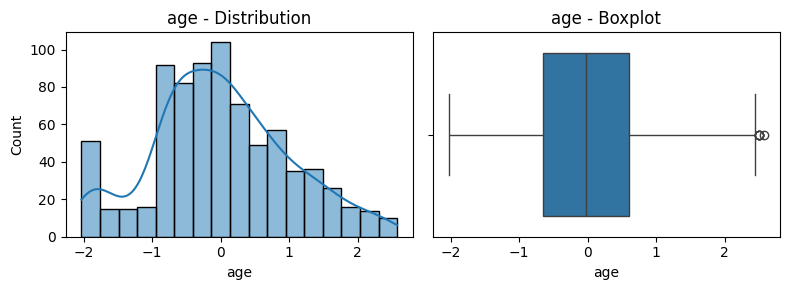

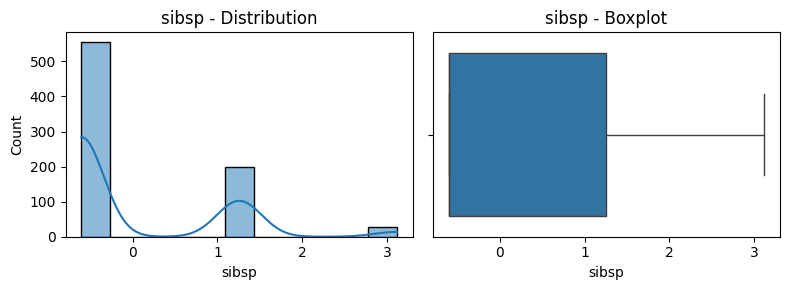

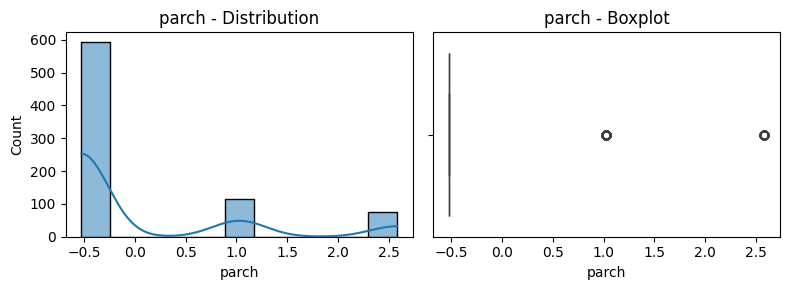

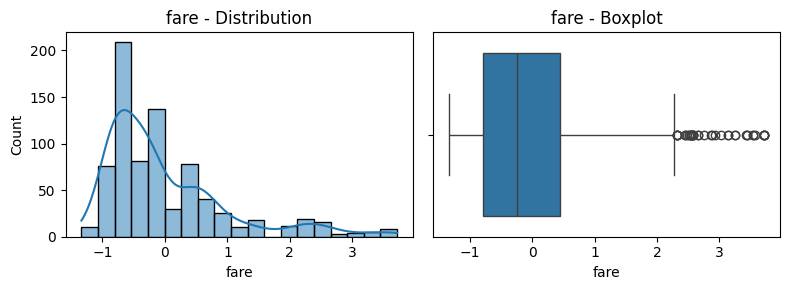

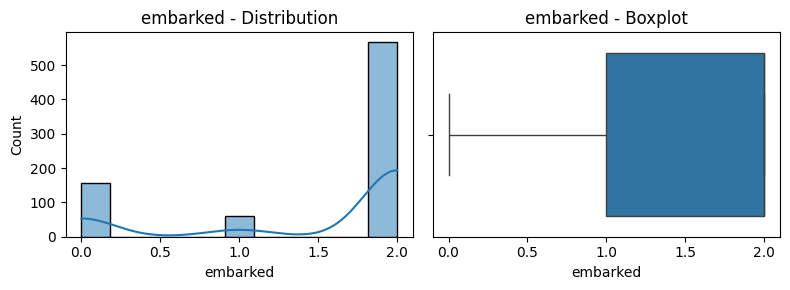

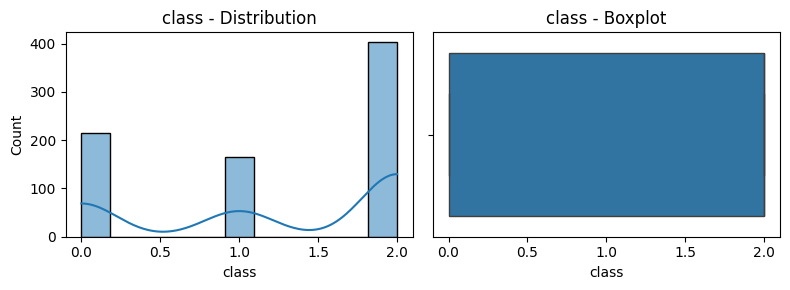

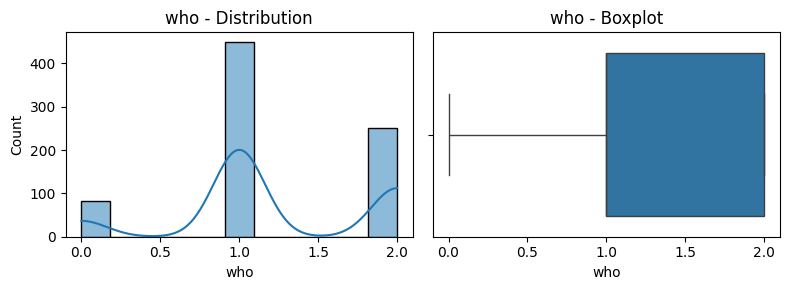

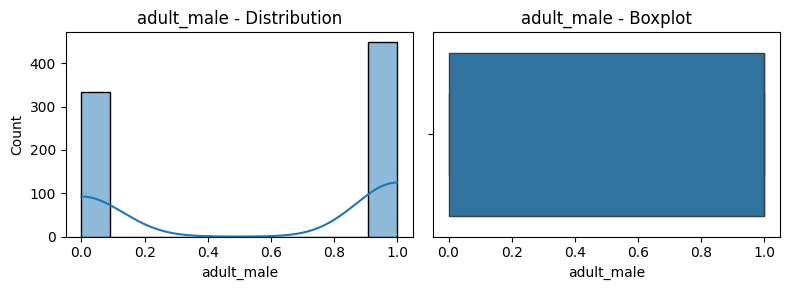

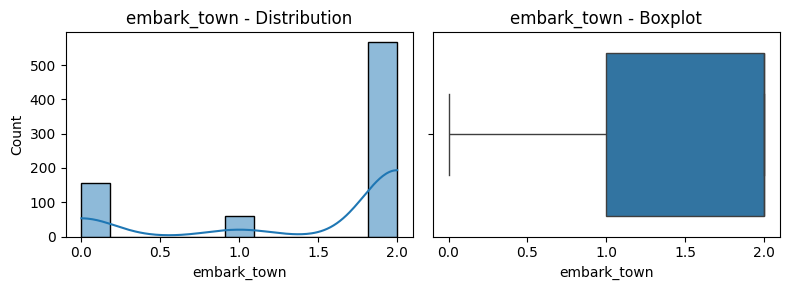

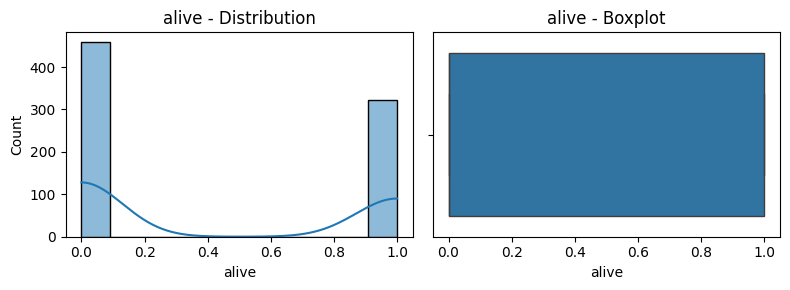

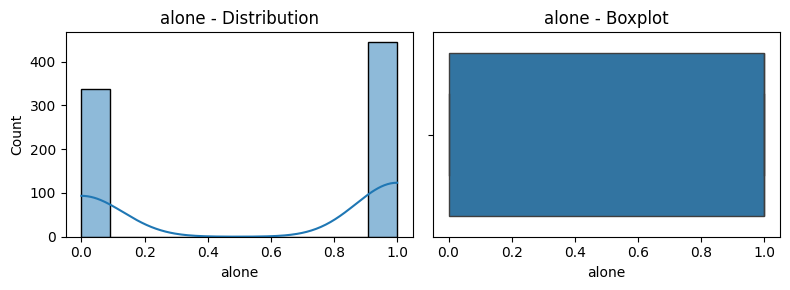

In [15]:
for column in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  
    sns.histplot(data=df[column], kde=True, ax=axes[0])
    sns.boxplot(data=df[column], ax=axes[1], orient='h')
    axes[0].set_title(f'{column} - Distribution')
    axes[1].set_title(f'{column} - Boxplot')
    plt.tight_layout()
    plt.show()

### EDA

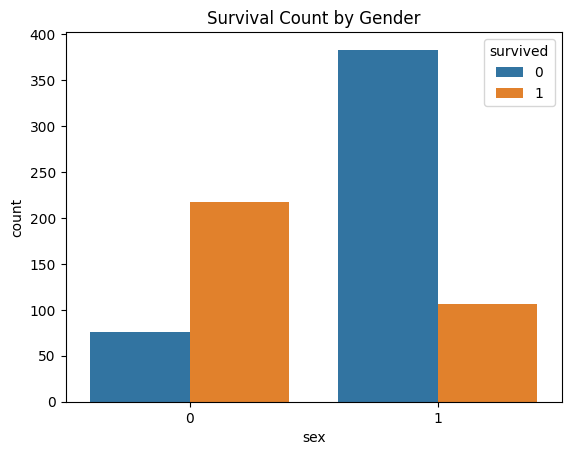

In [16]:
# Visualize Survival Rate by Gender
sns.countplot(x='sex', hue='survived', data=df)
plt.title('Survival Count by Gender')
plt.show()

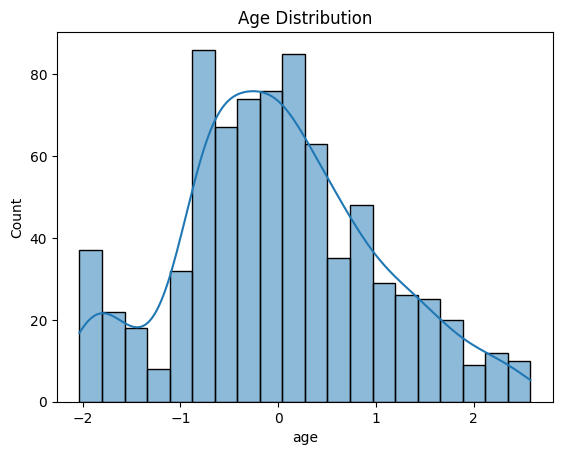

In [17]:
# Visualize Age Distribution
sns.histplot(data=df, x='age', bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

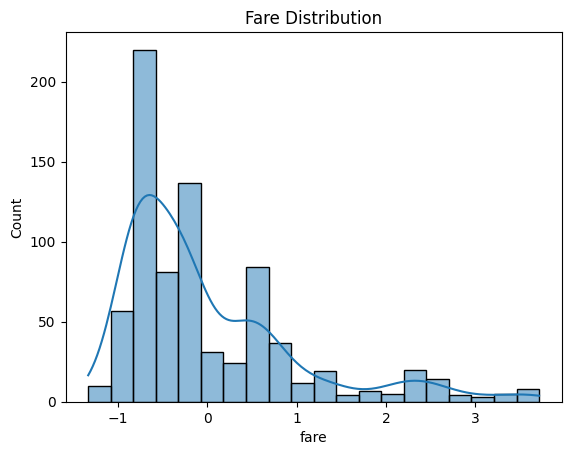

In [18]:
# Visualize Fare Distribution
sns.histplot(data=df, x='fare', bins=20, kde=True)
plt.title('Fare Distribution')
plt.show()

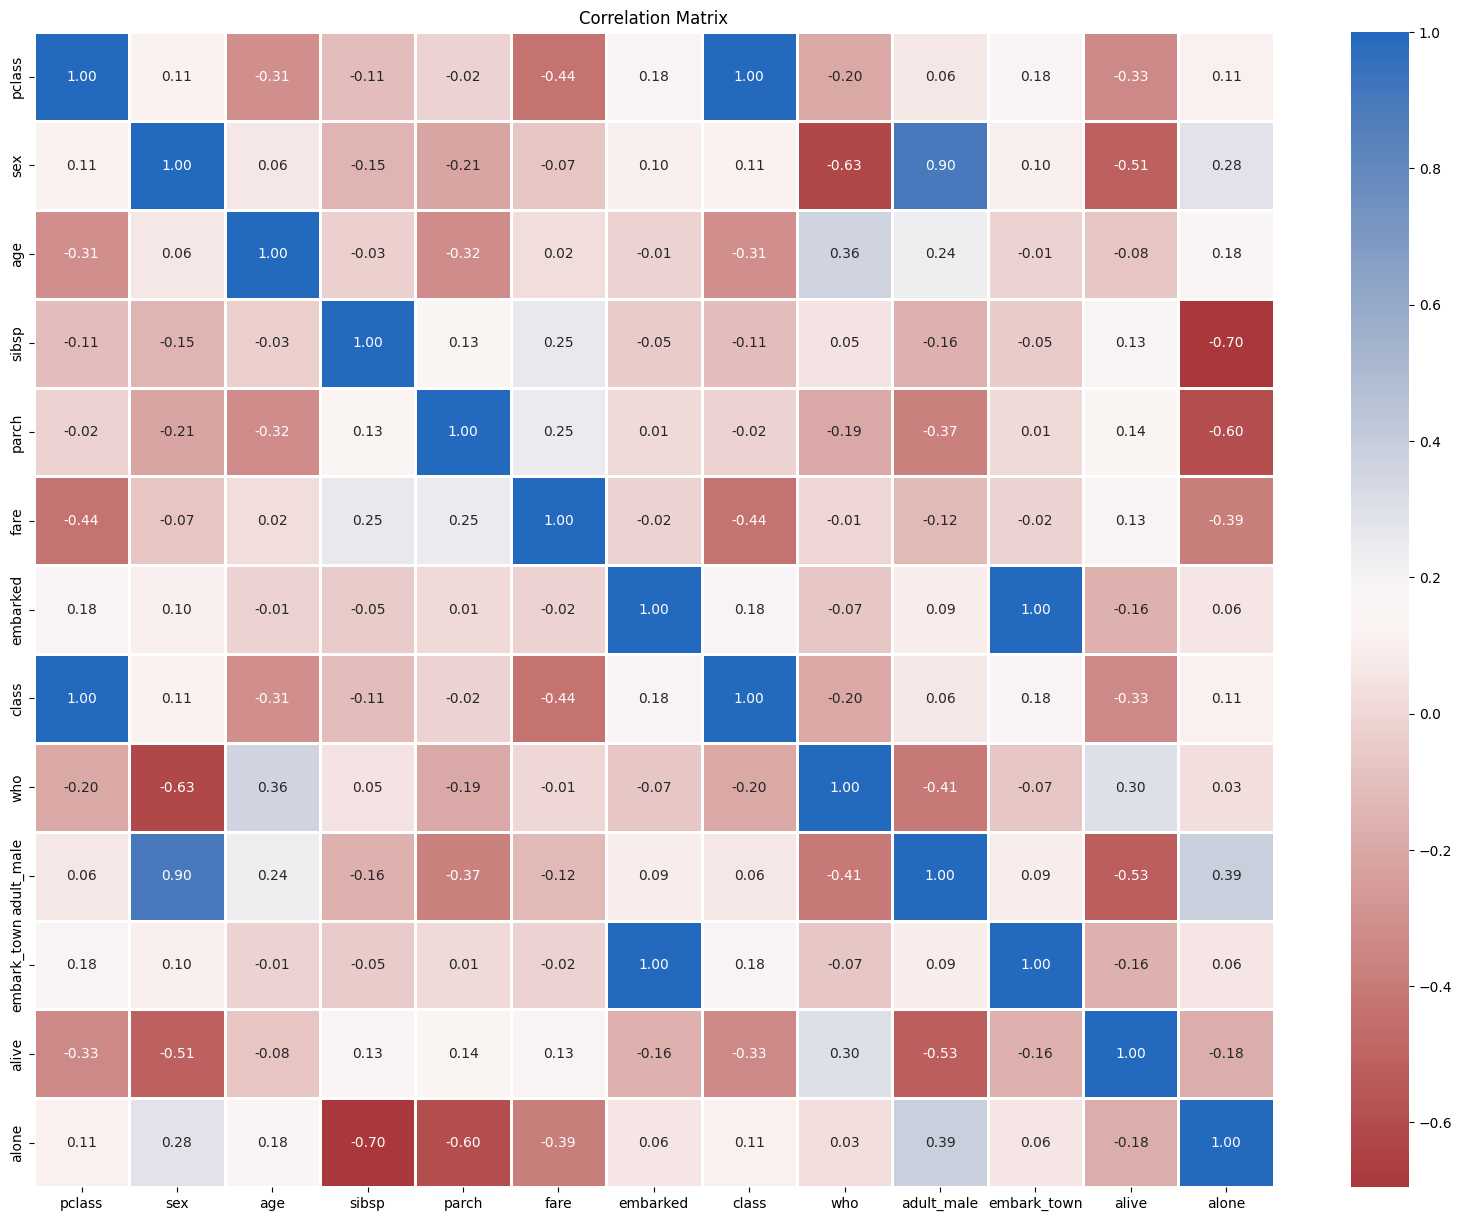

In [19]:
# Correlation Matrix
correlation_matrix = df.corr(method='pearson', numeric_only=True) 
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(numeric_only=True), cmap='vlag_r', annot=True, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix')
plt.show()

### Removing the duplicated columns

In [20]:
# The correlation matrix shows that there are 1 values which show us that there might be duplicated columns in the dataset
# Let's check for duplicated columns

duplicated_columns = [("embarked", "embark_town"), ("class", "pclass"),("alive", "survived")]
for cols in duplicated_columns:
    print(f"Correlation between {cols[0]} and {cols[1]}: {df[cols[0]].corr(df[cols[1]])}")

Correlation between embarked and embark_town: 0.9999999999999999
Correlation between class and pclass: 1.0
Correlation between alive and survived: 1.0


In [21]:
# Drop duplicated columns
df.drop(columns=['embark_town', 'pclass', 'alive'], inplace=True)

## Feature Engineering

In [22]:
## Selecting the features which are having high correlation with the target variable (survived)
target_corr = abs(df.corr()['survived']).sort_values(ascending=False)
print(target_corr)

survived      1.000000
adult_male    0.527633
sex           0.514972
class         0.331392
who           0.304517
alone         0.177287
embarked      0.160504
parch         0.136824
fare          0.129825
sibsp         0.126167
age           0.079082
Name: survived, dtype: float64


In [23]:
# Drop columns with low correlation
selected_features = target_corr[target_corr > 0.1].index.tolist()
selected_features.remove('survived')
selected_features

['adult_male',
 'sex',
 'class',
 'who',
 'alone',
 'embarked',
 'parch',
 'fare',
 'sibsp']

# Data splitting

In [24]:
X = df[selected_features]
y = df['survived']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

### SVM

In [27]:
# SVM Model
svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7261146496815286


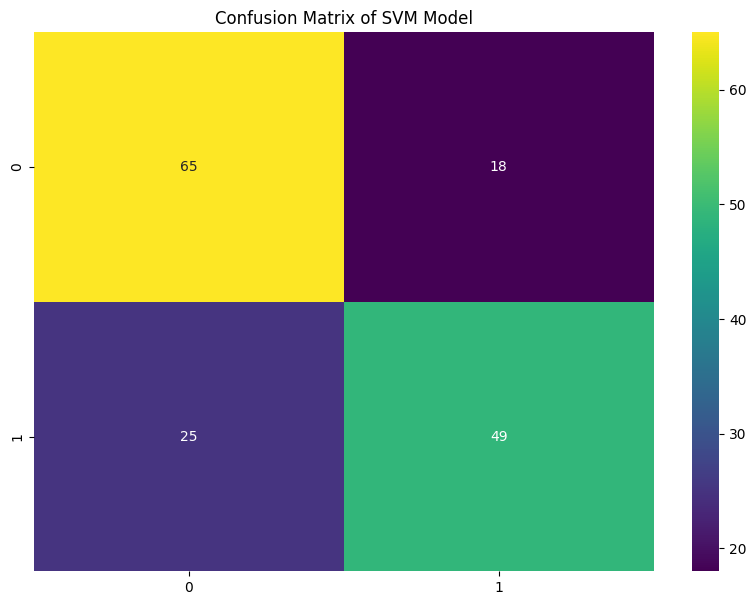

In [28]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of SVM Model')
plt.show()

### Logistic Regression

In [29]:
# Logistic Regression Model
model = LogisticRegression()
# Train the model
model.fit(x_train, y_train)

# Accuray Score on train dataset
predict_train = model.predict(x_train)
accuracy_train = accuracy_score(y_train, predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)

# Accuracy Score on test dataset
predict_test = model.predict(x_test)
accuracy_test = accuracy_score(y_test, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)


accuracy_score on train dataset :  0.808

accuracy_score on test dataset :  0.7197452229299363


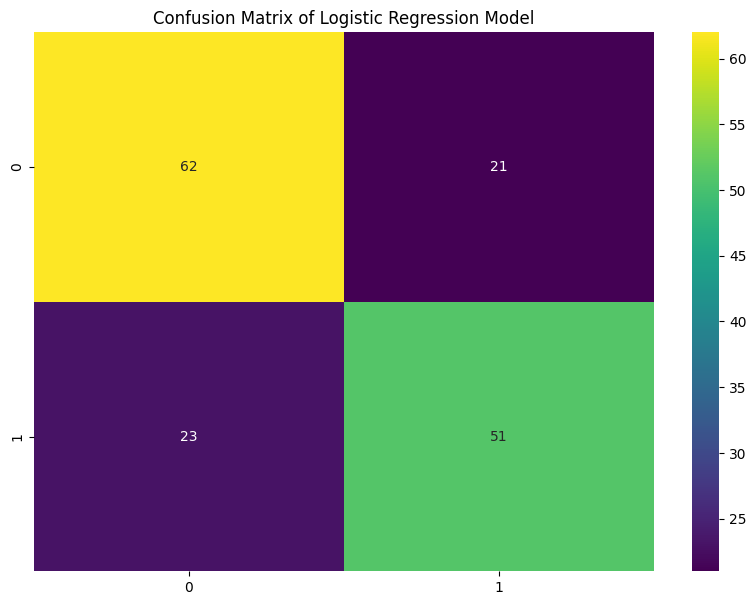

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, predict_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Logistic Regression Model')
plt.show()

### Random Forest

In [31]:
# Random Forest Model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7006369426751592


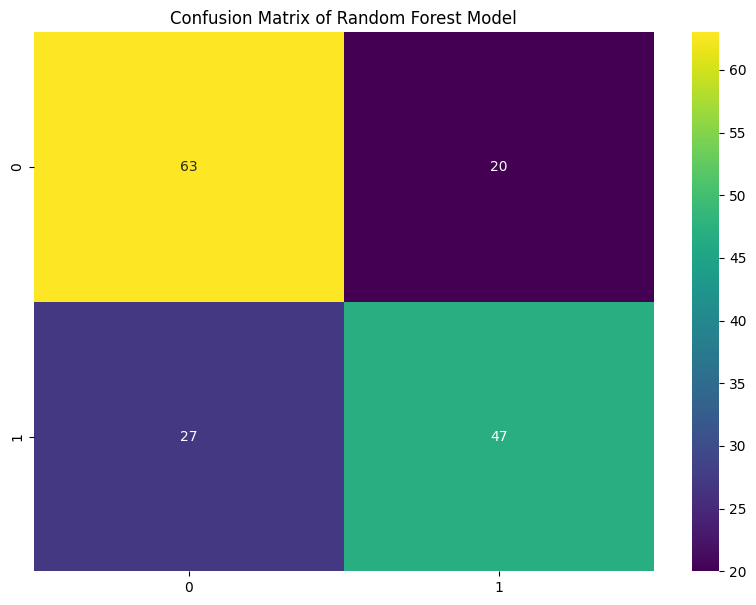

In [32]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix of Random Forest Model')
plt.show()